In [48]:
import pandas as pd
import numpy as np
from numpy.linalg import svd, eig
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix

# Always make it pretty.
plt.style.use('ggplot')

%matplotlib inline

In [138]:
import pickle
from gensim import matutils, models
import scipy.sparse

In [154]:
dk = pd.read_pickle('data/dk_clean.pkl')
fd = pd.read_pickle('data/fd_clean.pkl')

#import the Document Term Matrix
dk_tf_df = pd.read_pickle('data/dk_tf_df.pkl').transpose()
fd_tf_df = pd.read_pickle('data/dk_tf_df.pkl').transpose()

#import the vectorizers
dk_vectorizer = pickle.load(open('data/dk_vectorizer.pkl', 'rb'))
fd_vectorizer = pickle.load(open('data/fd_vectorizer.pkl', 'rb'))

dk_X = dk_vectorizer.fit_transform(dk.text)
fd_X = fd_vectorizer.fit_transform(fd.text)

# Modeling with All Text

In [155]:
#gensim format df --> sparse matrix --> gensim corpus
dk_sparse_counts = scipy.sparse.csr_matrix(dk_tf_df)
dk_corpus = matutils.Sparse2Corpus(dk_sparse_counts)

fd_sparse_counts = scipy.sparse.csr_matrix(fd_tf_df)
fd_corpus = matutils.Sparse2Corpus(fd_sparse_counts)

In [156]:
dk_corpus

In [157]:
#gensim requires dictionary of all term and location within the term-document matrix
dk_idx_2word = dict((v, k) for k, v in dk_vectorizer.vocabulary_.items())
fd_idx_2word = dict((v, k) for k, v in fd_vectorizer.vocabulary_.items())

In [158]:
len(dk_idx_2word)

1500

In [159]:
# DK Latent Dirichlet Allocation
# dk_lda = models.LdaModel(corpus=dk_corpus, id2word=dk_idx_2word, num_topics=2, passes=10)
# dk_lda.print_topics()

In [160]:
# DK Latent Semantic Indexing
dk_lsi = models.LsiModel(corpus=dk_corpus, id2word=dk_idx_2word, num_topics=2)
dk_lsi.print_topics()

[(0,
  '0.397*"dk" + 0.395*"entered" + 0.386*"nfl dfs" + 0.377*"dfs seahawks" + 0.332*"expertpicks" + 0.161*"thanksgiving slate" + 0.157*"post tonights showdown" + 0.155*"options" + 0.134*"shares" + 0.114*"fifth"'),
 (1,
  '0.354*"dfs" + 0.347*"rolling" + 0.288*"winner day" + 0.252*"ufc" + 0.232*"fanduel nfl dfs" + 0.222*"packers rts tweet" + 0.216*"follows ven" + 0.201*"tonights showdown lineup" + -0.192*"dk" + -0.187*"entered"')]

In [ ]:
dk_vocab = list(model.wv.vocab)
X = model[vocab]

In [86]:
#FD Latent Dirichlet Allocation
# fd_lda = models.LdaModel(corpus=fd_corpus, id2word=fd_idx_2word, num_topics=2, passes=10)
# fd_lda.print_topics()

In [192]:
#FD Latent Semantic Indexing
fd_lsi = models.LsiModel(corpus=fd_corpus, id2word=fd_idx_2word, num_topics=7)
fd_lsi.print_topics()

[(0,
  '-0.397*"discount vip" + -0.395*"fanduel draftkings" + -0.386*"ncaaf cbb" + -0.377*"dfs packers" + -0.332*"fanduel nfl" + -0.161*"today" + -0.157*"projections fanduel" + -0.155*"ownership rankings" + -0.134*"south" + -0.114*"free xef"'),
 (1,
  '-0.354*"defense streamers" + -0.347*"sea vs" + -0.288*"winner ut" + -0.252*"utarlington" + -0.232*"final" + -0.223*"person rts" + -0.216*"game rankings" + -0.201*"trying" + 0.192*"discount vip" + 0.187*"fanduel draftkings"'),
 (2,
  '-0.561*"going" + -0.535*"want advantage" + -0.379*"extra" + -0.222*"read" + -0.152*"single game" + -0.147*"strategy" + -0.144*"link xef" + -0.144*"super" + -0.073*"tie" + -0.069*"main slate"'),
 (3,
  '-0.259*"game rankings" + 0.253*"final" + 0.251*"trying" + 0.222*"spot today" + 0.207*"packers rts" + 0.206*"barstoolsportsbook draftkings" + 0.196*"fanduel nfl" + -0.186*"today" + 0.185*"utarlington" + -0.168*"games"'),
 (4,
  '0.297*"following" + 0.242*"xbe" + -0.232*"south" + 0.232*"winner ut" + 0.202*"thewa

# Modeling with only nouns

In [125]:
import nltk
from nltk import word_tokenize, pos_tag
nltk.download('averaged_perceptron_tagger')

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/LMC/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [126]:
dk_nouns = pd.DataFrame(dk.text.apply(nouns))
fd_nouns = pd.DataFrame(fd.text.apply(nouns))

In [135]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Re-add the additional stop words since we are recreating the document-term matrix
add_stop_words = ['co', 'nfl', 'dfs', 'draftkings', 'fanduel', 'n', 'vs', 'xef', 'rts', 'snf', 'dk', 'rts', 
                  'mnf', 'nmust']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate a document-term matrix with only nouns
vectorizern = TfidfVectorizer(stop_words=stop_words, max_df = .8)

In [136]:
dk_vectorizer = vectorizern.fit_transform(dk_nouns.text)
dk_tf_df = pd.DataFrame(dk_vectorizer.toarray(), columns=vectorizern.get_feature_names())
dk_tf_df.index = dk_nouns.index

# Create the gensim corpus
dk_corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(dk_tf_df.transpose()))

# Create the vocabulary dictionary
dk_id2wordn = dict((v, k) for k, v in vectorizern.vocabulary_.items())

# DK Latent Semantic Indexing
dk_lsi = models.LsiModel(corpus=dk_corpusn, id2word=dk_id2wordn, num_topics=2)
dk_lsi.print_topics(num_words = 5)

[(0,
  '-0.543*"dailysportpickz" + -0.432*"tweet" + -0.362*"packers" + -0.360*"person" + -0.315*"bears"'),
 (1,
  '0.588*"fantasyfootball" + 0.533*"projections" + 0.419*"ownership" + 0.269*"game" + 0.205*"rankings"')]

In [137]:
fd_vectorizer = vectorizern.fit_transform(fd_nouns.text)
fd_tf_df = pd.DataFrame(fd_vectorizer.toarray(), columns=vectorizern.get_feature_names())
fd_tf_df.index = fd_nouns.index

# Create the gensim corpus
fd_corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(fd_tf_df.transpose()))

# Create the vocabulary dictionary
fd_id2wordn = dict((v, k) for k, v in vectorizern.vocabulary_.items())

# DK Latent Semantic Indexing
fd_lsi = models.LsiModel(corpus=fd_corpusn, id2word=fd_id2wordn, num_topics=2)
fd_lsi.print_topics(num_words = 5)

[(0,
  '-0.588*"dailysportpickz" + -0.407*"tweet" + -0.322*"person" + -0.282*"packers" + -0.255*"giveaway"'),
 (1,
  '-0.589*"fantasyfootball" + -0.545*"projections" + -0.442*"ownership" + -0.222*"game" + -0.207*"rankings"')]

LSI provides both positive and negative weights per topic. A positive weight means the word is highly representative of a topic, while a negative weight means the word is highly unrepresentative of a topic (the less it occurs in a text, the more likely the topic).

# Modeling with Nouns and Adjectives

In [130]:
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [132]:
dk_nouns_adj = pd.DataFrame(dk.text.apply(nouns_adj))
fd_nouns_adj = pd.DataFrame(fd.text.apply(nouns_adj))

In [189]:
vectorizerna = TfidfVectorizer(stop_words=stop_words, max_df = .8)
dk_vectorizerna = vectorizerna.fit_transform(dk_nouns_adj.text)
dk_na = pd.DataFrame(dk_vectorizerna.toarray(), columns=vectorizerna.get_feature_names())
dk_na.index = dk_nouns_adj.index

# Create the gensim corpus
dk_corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(dk_na.transpose()))

# Create the vocabulary dictionary
dk_id2wordna = dict((v, k) for k, v in vectorizerna.vocabulary_.items())

# DK Latent Semantic Indexing
dk_lsi = models.LsiModel(corpus=dk_corpusna, id2word=dk_id2wordna, num_topics=2)
dk_lsi.print_topics(num_words = 5)


[(0,
  '0.483*"dailysportpickz" + 0.399*"tweet" + 0.376*"tonight" + 0.333*"packers" + 0.318*"person"'),
 (1,
  '-0.627*"fantasyfootball" + -0.355*"projections" + -0.318*"ownership" + -0.290*"game" + -0.275*"single"')]

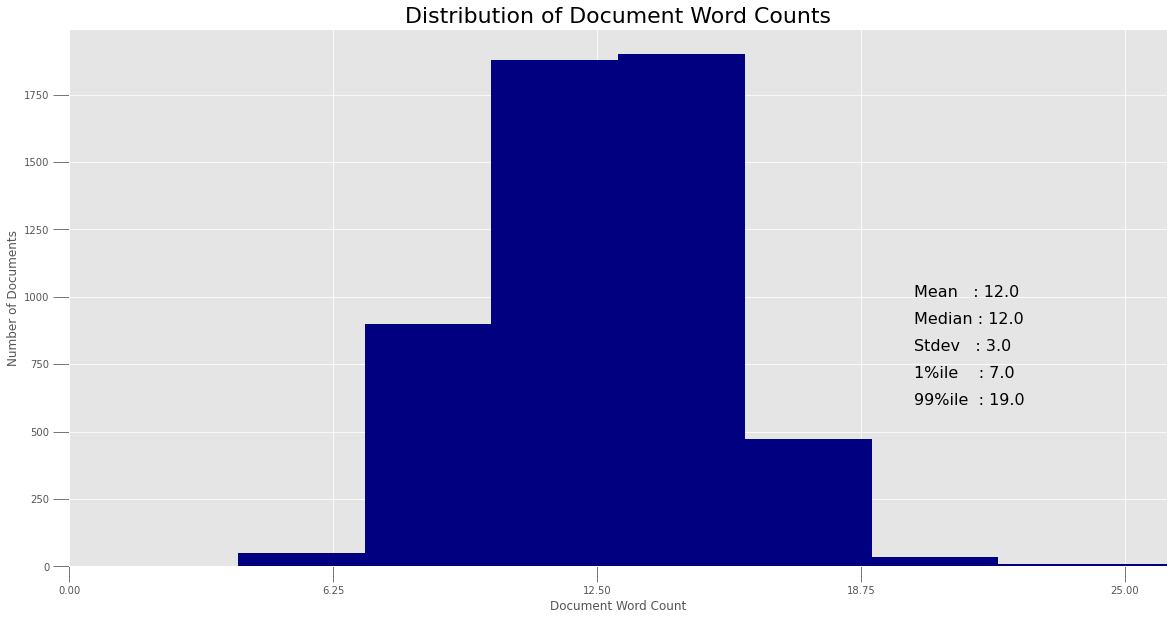

In [185]:
doc_lens = [len(d.split()) for d in dk.text]

# Plot
plt.figure(figsize=(16,8))
plt.hist(doc_lens, bins = 10, color='navy')
plt.text(20, 1000, "Mean   : " + str(round(np.mean(doc_lens))), size = 16)
plt.text(20,  900, "Median : " + str(round(np.median(doc_lens))), size = 16)
plt.text(20,  800, "Stdev   : " + str(round(np.std(doc_lens))),  size = 16)
plt.text(20,  700, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))),  size = 16)
plt.text(20,  600, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))),  size = 16)
plt.tight_layout()

plt.gca().set(xlim=(0, 26), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,25,5))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

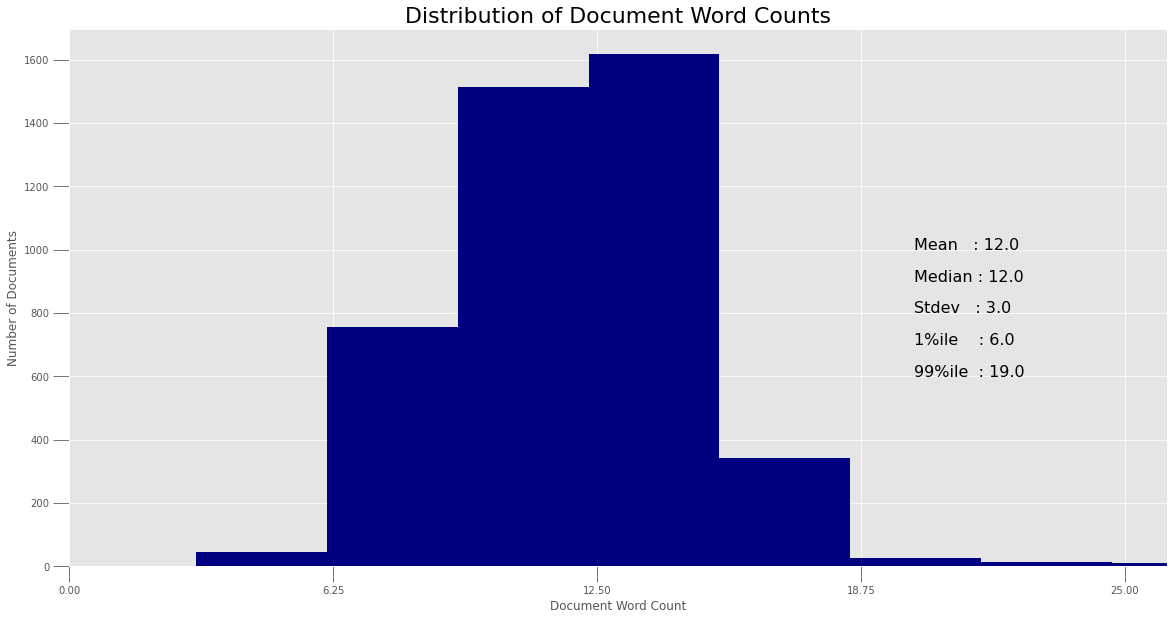

In [186]:
doc_lens = [len(d.split()) for d in fd.text]

# Plot
plt.figure(figsize=(16,8))
plt.hist(doc_lens, bins = 10, color='navy')
plt.text(20, 1000, "Mean   : " + str(round(np.mean(doc_lens))), size = 16)
plt.text(20,  900, "Median : " + str(round(np.median(doc_lens))), size = 16)
plt.text(20,  800, "Stdev   : " + str(round(np.std(doc_lens))),  size = 16)
plt.text(20,  700, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))),  size = 16)
plt.text(20,  600, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))),  size = 16)
plt.tight_layout()

plt.gca().set(xlim=(0, 26), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,25,5))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()